# Lesson: degree day model

Today we are going to use the [degree day model](http://www.antarcticglaciers.org/glaciers-and-climate/numerical-ice-sheet-models/modelling-glacier-melt/) (DDM) as a pretext to learn a little bit more about logical tools in numpy/pandas.


**Spend some time to read the webpage linked above explaining how the simple degree day model works.**

We will use the AWS data at Zhadang, but in a good shape this time (with variable names and corrected time, its on OLAT: data_Zhadang_localtime.csv

In [1]:
# imports and defaults
import pandas as pd  
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
pd.options.display.max_rows = 14
import seaborn as sns
sns.set_style('ticks')
sns.set_context('talk')

In [2]:
# read the data
df = pd.read_csv('data_Zhadang_localtime.csv', index_col=0, parse_dates=True)

The DDM works best with daily (or sometimes even monthly) time steps. So we resample:

In [3]:
# resample 
df = df.resample('D').mean()
# note that such 'temperature index' approaches can really be applied, hourly, daily, monthly or whatever. 
# the principle is the same, though in cryopsheric science the daily timescale is most widely used

To test the model, we are concentrating on the melting season 2012, which I define as follows:

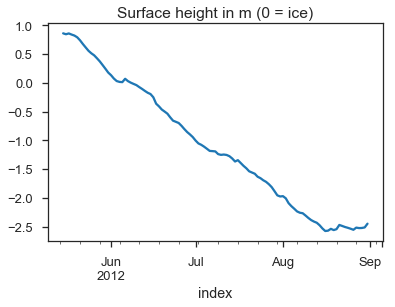

In [4]:
# from the middle of May onwards
# here we assume that it starts snowing hard on 01. September :-)
df = df.loc['2012-05-15':]
# how can we see if ablation is happening?
# we can check that the surface is lowering during this period ....
df['SR50'].plot(title='Surface height in m (0 = ice)');

## 1. Simplest DDM

For the simplest DDM, we are going to use a single factor for the entire melting period. The DDM formulation is very simple:

$$Melt = f \cdot PDD$$

Where PDD is the sum total of daily average temperatures above 0°C in a given time period and f is a melting factor. Let's define the melt in meters of snow/ice which is melted away. Determine the unit that $f$ should have in that (quite clumsy) case.

OK, so now we need to count the PDD's over that period. One method that you already learned is following:

In [5]:
# select all days with mean temperature above 0
seltemp = df.TEMP.loc[df.TEMP > 0]
# sum these daily mean temperatures
seltemp.sum()

251.98720833333334

For the purpose of our modelling, however, it is easier to define a new variable (PDD), which is the daily average of temperature when it is above 0°C, and zero otherwise. For this we are using the numpy function [np.where](http://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.where.html):

In [48]:
df['PDD'] = np.where(df.TEMP > 0, df.TEMP, 0)
# this means we have a PDD value for each day from which we can compute expected melt for each day
print(df)

              PRESSURE     ANGLE  WINDSPEED     NETRAD         RH        SWIN  \
index                                                                           
2012-05-15  502.202125  1.497000   3.067500  31.913333  47.953875  368.652625   
2012-05-16  501.291625  1.509417   2.972583  57.274958  66.343542  337.166833   
2012-05-17  504.092292  1.522625   2.848375 -15.740083  75.818542  310.270500   
2012-05-18  506.127042  1.520000   3.519167  30.017542  43.228708  371.586000   
2012-05-19  505.273708  1.625417   5.256792  85.459583  47.250625  372.502792   
2012-05-20  504.533417  1.575417   3.688333  75.698667  54.379583  352.009458   
2012-05-21  504.273708  1.509958   2.576875  93.990417  49.034250  371.238083   
...                ...       ...        ...        ...        ...         ...   
2012-08-25  509.486083  5.090167   2.739417  33.315500  48.891917  291.140417   
2012-08-26  508.334000  4.482000   3.889042  34.122917  71.634083  265.964875   
2012-08-27  507.686167  4.26

**Q: Read the documentation for np.where. Try it out with simple data. Can you understand what it does? Verify that the the sum of this  new PDD variable corresponds to our computation above.**

In [7]:
# so as you'll have seen from the documentation, its a conditional location
# by summing it we can verify that its the same as the answer above - yay!
df.PDD.sum()

251.98720833333334

In [8]:
# bearing in mind that our defined melt season is only 3.5 months long ...
# just eyeballing this number it seems quite high ...
# so either there are loads of positive mean temperatures, or there are some 'heatwave' days ...
# to find out which
seltemp.size / df.TEMP.size * 100
# so 100 or the 109 days have positrive mean temperatures, which is more than I expected for Tibet

91.74311926605505

Now we are going to calibrate our model, i.e. we are computing our factor $f$. The total of snow/ice melt (in m) during this period is:

In [9]:
# in this case we look at the total surface lowering in metres
obs_melt = df.SR50.iloc[-1] - df.SR50.iloc[0]  
# what is iloc[] by the why? Ask the notebook!
# index location [0 to (length)-1]
obs_melt
# its worth noting that in most glaciolohgical applications this ablation would be expressed differently
# e.g. as lowering in units of water equivalent (e.g. mm w.e.) which is numerically equivalent to km/m^3

-3.309333333333333

Which gives us a melt factor:

In [10]:
# so looking at the formula above ...
melt_factor = obs_melt / df['PDD'].sum()
melt_factor

-0.013132941768042788

It is now very easy to define a variable (MELT1), which is the daily melt due to this factor:

In [11]:
df['MELT1'] = df['PDD'] * melt_factor

**Q: Plot this new variable. What are we looking at?**

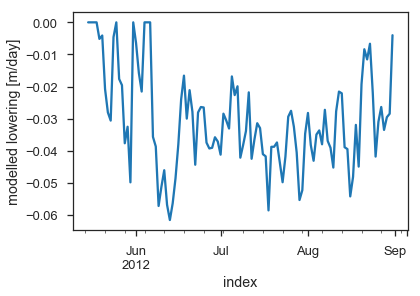

In [17]:
df['MELT1'].plot();
plt.ylabel('modelled lowering [m/day]');

In order to compare this melt with observations, we should compute its cumulative sum: 

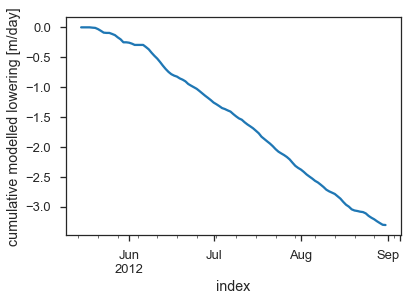

In [18]:
# so actually we are seeking to compare to our cumulative surface lowering measured by the sonic ranger
df['MELT1'] = (df['PDD'] * melt_factor).cumsum()
df['MELT1'].plot();
plt.ylabel('cumulative modelled lowering [m/day]');

If you plot this variable again, you will see that something is still missing. Therefore, we now add the starting snow depth to this timeseries. We select the first element of the observations array with `iloc[]` and add it to ours:

In [19]:
df['MELT1'] = (df['PDD'] * melt_factor).cumsum() + df.SR50.iloc[0]

Done! Let's plot the result of our modeling approach:

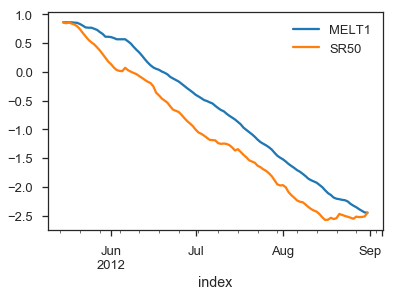

In [20]:
df[['MELT1', 'SR50']].plot();

**Q: Discuss the performance of our model. Where is it performing well? Where is it performing less well? Can you tell why?**

In [ ]:
# so consider the slopes of the curves
# up until the third week of June the model does not match too well, nor in the last 2 weeks of August
# in the middle section, although there is am offset the curves are quite well matched
# if we look back at our plot of the surface height, we know:
# there was snow (i) at the beginning, and (ii) probably small snow events at the end of the record ...
# OR ... the surface height changes at the end could be related to tilting of the AWS?
# note that the way this model is calibrated means that the final surface ehight *will* match

## 2. A more reasonable DDM

It is more reasonable to distinguish between snow and ice in our model. Fortunately, the person who provided the data nicely set the 0 level to the original ice surface before the ablation season.

**Q: Add a new variable IS_SNOW to the dataframe, which is equal to True when the surface is above 0 and to False otherwise.**

In [21]:
# lets take care of the snow that is removed during the first part of the ablation season
df['IS_SNOW'] = np.where(df.SR50 > 0, True, False)

We are now computing the melt factor for the snowmelt period:

In [23]:
# first, compute the PDD sum during the snowmelt period:
pdd_snow = df.PDD.loc[df['IS_SNOW']].sum()
# then, compute the observed melt during this period:
melt_snow = - df.SR50.iloc[0]
# finally, compute the factor:
fac_snow = melt_snow / pdd_snow
fac_snow

-0.030694767161320496

For the ice surface, we have to introduce a new operator, "~". This is the logical operator for "not":

In [25]:
# you can see the behavior by doing this:
print(np.array([True, False, True]))
print(~ np.array([True, False, True]))

[ True False  True]
[False  True False]


Once we have this, computing the PDD sum during the ice period is easy:

In [26]:
# first, compute the PDD sum during the ice melt period:
pdd_ice = df.PDD.loc[~ df['IS_SNOW']].sum()  # note the ~
# then, compute the observed melt during this period. 
melt_ice = df.SR50.iloc[-1]
# Finally, compute the factor:
fac_ice = melt_ice / pdd_ice
fac_ice

-0.010931945060044752

**Q: compare the two factors. Discuss their relative value in light of the physical properties of snow and ice. Does it make sense for you?**

In [31]:
# so what do we see?
# for each PDD the lowering of the snow surface is 3 times as much as the ice surface
# would you expect that?
# remember that we are dealing with the rate of surface lowering of 2 different things: snow and ice
# the density of ice is ~900kg/m3, but snow is less dense (even old snow)
# so we might expect the lowering rate to be more per unit of our temperature index

# but what if our calculations were based on ablation in terms of water equivalents or mass instead of surface lowering?
# then the higher reflectance of snow might mean the melt factor for snow is smaller than for ice

**Q: Define a new variable (MIXED_FAC) in the dataframe, which is equal to fac_snow during the snow period and to fac_ice otherwise. Using the same approach as before, compute a new variable MELT2 wich is the cumulative melt during that period. Plot it together with the SR50 observations.**

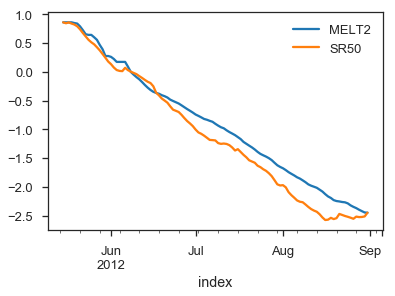

In [32]:
df['MIXED_FAC'] = np.where(df['IS_SNOW'], fac_snow, fac_ice)
df['MELT2'] = (df['PDD'] * df['MIXED_FAC']).cumsum() + df.SR50.iloc[0]
df[['MELT2', 'SR50']].plot();

**Q: Discuss the performance of our new model. Is it performing better than before? Can you tell why?**

In [69]:
# ok so we have improved it, right?
# but we have not corrected for the snow at the end of our 'ablation' season
# remember these positive changes could be associated with tilting, but if not ...
# then it actually means the ablation season finished earlier than we thought

# I don't know how to get the index (date) of the SR50 minimum (sorry! I bet you guys know) 
# so I'll just have a look to find the date
# option 1:
end = df.loc[df.SR50 == df.SR50.min()]
print(end)
# ... then I can look at the index and see it is 16 August

# option 2:
print(df.SR50.min()) # display the minmum value
print(df.SR50.loc['2012-08-10': '2012-08-20']) # dispay the range it will lie within and cross check

              PRESSURE      ANGLE  WINDSPEED      NETRAD        RH  \
index                                                                
2012-08-16  509.245125  15.724958   2.807625  167.290542  69.16375   

                  SWIN      SR50      TEMP      SWOUT     WINDDIR  SURFTEMP  \
index                                                                         
2012-08-16  287.104917 -2.575292  4.127167  61.095792  164.510375 -0.926667   

            PRCP       PDD     MELT1  IS_SNOW  MIXED_FAC     MELT2  
index                                                               
2012-08-16   0.0  4.127167 -2.060471    False  -0.010932 -2.125405  
-2.5752916666666668
index
2012-08-10   -2.347750
2012-08-11   -2.385000
2012-08-12   -2.411250
2012-08-13   -2.431667
2012-08-14   -2.474833
2012-08-15   -2.530500
2012-08-16   -2.575292
2012-08-17   -2.569292
2012-08-18   -2.537500
2012-08-19   -2.558875
2012-08-20   -2.543167
Freq: D, Name: SR50, dtype: float64


In [71]:
# so I know the minimum of the mean surface height is on the 16th
# I can trim down my dataframe
df = df.loc['2012-05-15' :'2012-08-16']
# and repeat he excercise:
# first, compute the PDD sum during the snowmelt period:
pdd_snow = df.PDD.loc[df['IS_SNOW']].sum()
# then, compute the observed melt during this period:
melt_snow = - df.SR50.iloc[0]
# finally, compute the factor:
fac_snow = melt_snow / pdd_snow
print(fac_snow)
# first, compute the PDD sum during the ice melt period:
pdd_ice = df.PDD.loc[~ df['IS_SNOW']].sum()  # note the ~
# then, compute the observed melt during this period. 
melt_ice = df.SR50.iloc[-1]
# Finally, compute the factor:
fac_ice = melt_ice / pdd_ice
print(fac_ice)
# note the change in the fac_ice value

-0.030694767161320496
-0.013245923000183237


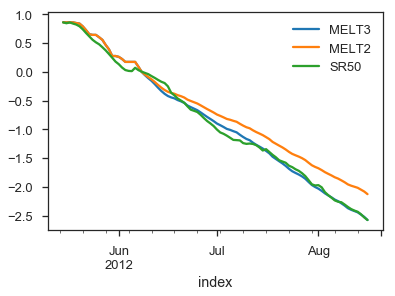

In [74]:
# lets have a look at that then
df['MIXED_FAC2'] = np.where(df['IS_SNOW'], fac_snow, fac_ice)
df['MELT3'] = (df['PDD'] * df['MIXED_FAC2']).cumsum() + df.SR50.iloc[0]
df[['MELT3', 'MELT2', 'SR50']].plot();

Tthis is a good example of how more perfect information can result in a better performance for this type of empirically fitted model
Do we know if these factors are 'right'? 
Do you expect them to work perfectly in 2013, or any other year, or on another part of the glacier?

What else have we not accounted for?
Well, although the season we are studying is relatively short, conditions still might change throughout it
the temperaure index (PDD) model we applied, assumes that temperature captures a whole bunch of atmospheric energy sources
If the relative importance of these change over the ablation season change substantially the melt factor might too

## 3. An even more reasonable DDM

In our previous models, we compeletely neglected snowfall, which of course is bad. If you are ambitious, you can try to propose solutions to this problem.

Now you can continue with the next exercise (on OLAT as usual).

I'm not sure how I'd do this in python but here is a potential workflow:

 * probably begin with calcualting a cumulative minimum variable ...
 * and check if each day surface height is above this to identify short lived snowcover within the ablation season ...
 * then revise the IS_SNOW index accordingly to add snowcovered events within the ablation season ...
 * then, summing the PDD over this new IS_SNOW index is straightforward:
 *  total ice lowering remains easy - its the minimum surface height in this case
 *  total snow lowering would need you to sum the total snow over the defined ablation season
 * then use the PDD sums with the total lowering separated for each surface type to get the melt factors ...
 * finally re-run the model applying the differnt metl factors depending on the surface type